# **Previsão do Preço de Fechamento da Ação ITUB4.SA com Machine Learning**
Este projeto tem como objetivo desenvolver um modelo preditivo capaz de antecipar o preço de fechamento diário da ação **Itaú Unibanco (ITUB4.SA)**, listada na B3 (Brasil, Bolsa, Balcão), utilizando técnicas de **Machine Learning com redes neurais LSTM**. 

A escolha do Itaú se justifica por sua:
- Alta liquidez e representatividade no mercado acionário brasileiro;
- Histórico robusto de cotações (disponível desde 2014);
- Relevância econômica como um dos maiores bancos privados do Brasil.

O modelo foi desenvolvido seguindo boas práticas de séries temporais financeiras e está alinhado aos requisitos do **Tech Challenge Fase 4**, incluindo deploy em API RESTful e containerização com Docker.

## **Importação de Bibliotecas**

In [31]:
# Coleta e manipulação de dados
import yfinance as yf
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e métricas
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Modelagem com TensorFlow/Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

import random
import os

# Séries Temporais
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller

# Salvamento de artefatos
import joblib

# Configurações
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## **1. Coleta de Dados via yfinance**

Para este projeto, coletamos os dados históricos da ação **Itaú Unibanco (ITUB4.SA)** utilizando a biblioteca **[yfinance](https://pypi.org/project/yfinance/)**, que acessa o Yahoo! Finance — uma fonte confiável e amplamente utilizada para dados financeiros de ações listadas na B3.

Com o objetivo de capturar múltiplos ciclos econômicos (incluindo períodos de crise e expansão), definimos uma janela histórica de **10 anos** de dados diários (2014–2025), garantindo robustez ao modelo LSTM.

Os dados retornados contêm diversas colunas, mas focamos exclusivamente em:
- `Date` (índice do DataFrame): Data da cotação
- `Close`: Preço de fechamento da ação ITUB4.SA em BRL

Após a coleta, realizamos as seguintes transformações:
1. Seleção apenas da coluna `Close`;
2. Remoção de valores nulos;
3. Validação do período histórico coletado.

Essa abordagem garante dados limpos, consistentes e prontos para modelagem, alinhada às melhores práticas em séries temporais financeiras.

In [32]:
def coletar_itau():
    """
    Coleta dados históricos da ação ITUB4.SA usando yfinance.
    Retorna um DataFrame com a coluna 'Close'.
    """
    try:
        # Define o período de coleta: 10 anos (2014–2025)
        start_date = "2014-01-01"
        end_date = "2025-07-20"

        # Baixar dados diretamente com período explícito
        df = yf.download("ITUB4.SA", start=start_date, end=end_date)
        
        if df.empty:
            raise Exception("Nenhum dado retornado pelo yfinance")
        
        # Selecionar apenas o preço de fechamento
        df = df[['Close']].copy()
        df.columns = ['Close']
        
        # Garantir que o índice seja DatetimeIndex sem fuso horário
        df.index = pd.to_datetime(df.index).tz_localize(None)
        
        return df
    
    except Exception as e:
        raise Exception(f"Erro ao coletar ITUB4.SA via yfinance: {e}")

# Coletar e validar
try:
    df_itau = coletar_itau()
    assert len(df_itau) > 0, "Falha: Dados da ITUB4.SA estão vazios"
    print(f"ITUB4.SA coletado: {len(df_itau)} dias\n")
    print(df_itau.head())
except Exception as e:
    print(f"Erro ao coletar ITUB4.SA: {e}")
    raise

[*********************100%***********************]  1 of 1 completed

ITUB4.SA coletado: 2871 dias

               Close
Date                
2014-01-02  7.057965
2014-01-03  7.044530
2014-01-06  7.055723
2014-01-07  7.001986
2014-01-08  7.111708


## **2. Análise Inicial da Série Temporal: Qualidade e Características dos Dados**

Antes de prosseguir com a modelagem, é essencial avaliar a qualidade, integridade e estrutura da série temporal de preços de fechamento da ação ITUB4.SA. Essa etapa garante que os dados sejam confiáveis, completos e adequados para treinamento de modelos de Machine Learning.

Realizamos as seguintes verificações:

### 2.1 Informações Básicas do DataFrame

- Período coberto: início e fim da série;
- Frequência: diária (dias úteis da B3);
- Número total de observações;
- Tipo de índice: DatetimeIndex, sem fuso horário.

In [33]:
print("=== Informações Básicas ===")
print(f"Período: {df_itau.index.min().date()} a {df_itau.index.max(). date()}")
print(f"Frequência: diária (B3)")
print(f"Número de observações: {len(df_itau)}")
print(f"Tipo do índice: {type(df_itau.index)}")
print(f"Fuso horário: {df_itau.index.tz}")

=== Informações Básicas ===
Período: 2014-01-02 a 2025-07-18
Frequência: diária (B3)
Número de observações: 2871
Tipo do índice: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Fuso horário: None


### 2.2 Verificação de Valores Ausentes e Duplicatas

- Valores nulos (NaN): identificação de lacunas na série;
- Dias duplicados: verificação de registros repetidos;
- Consistência temporal: ausência de saltos irregulares.

In [34]:
print("\n=== Qualidade dos Dados ===")
print(f"Valores nulos (NaN): {df_itau.isnull().sum().sum()}")
print(f"Dias duplicados: {df_itau.index.duplicated().sum()}")
print(f"Índice ordenado cronologicamente: {df_itau.index.is_monotonic_increasing}")

# Verificar gaps (diferença entre dias > 1)
date_diff = df_itau.index.to_series().diff().dt.days
max_gap = date_diff.max()
print(f"Maior gap entre datas (dias): {int(max_gap)}")


=== Qualidade dos Dados ===
Valores nulos (NaN): 0
Dias duplicados: 0
Índice ordenado cronologicamente: True
Maior gap entre datas (dias): 5


## **3. Pré-processamento da Série Temporal: Preparando os Dados para Modelagem**
Agora que validamos a qualidade da série histórica do Itaú Unibanco (Seção 2), partimos para o pré-processamento necessário à modelagem com LSTM.

Como estamos trabalhando com um modelo univariado, nosso conjunto de dados final consiste apenas na coluna Close, já limpa e pronta para normalização e criação de sequências temporais.

Esta etapa garante que o modelo receba uma série contínua, sem falhas, alinhada às melhores práticas de séries temporais financeiras.

In [35]:
df_final = df_itau[['Close']].copy()

print("Dados prontos para modelagem!")
print(f"Forma final: {df_final.shape}")
print("\nInformações do índice:")
print(f"Tipo: {type(df_final.index)}")
print(f"Fuso horário: {df_final.index.tz}")

# Mostrar primeiras linhas
df_final.head()

Dados prontos para modelagem!
Forma final: (2871, 1)

Informações do índice:
Tipo: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Fuso horário: None


,Close
Date,
2014-01-02,7.057965
2014-01-03,7.044530
2014-01-06,7.055723
2014-01-07,7.001986
2014-01-08,7.111708


## **4. Análise Exploratória de Dados (EDA): Entendendo o Comportamento do Mercado**

Com os dados da ação Itaú Unibanco (ITUB4.SA) coletados, limpos e validados, iniciamos a fase de análise exploratória. O objetivo aqui é investigar o comportamento da série histórica de preços de fechamento para extrair insights que guiarão a modelagem. Buscaremos responder a perguntas como:

- Qual é o comportamento geral do preço de fechamento do Itaú no período?
- Como estão distribuídos os preços?
- Existe tendência clara ou sazonalidade?
- A volatilidade é compatível com um ativo de renda variável líquido?

Essa etapa é crucial porque um bom modelo de Machine Learning começa com uma boa compreensão dos dados. Através de visualizações e estatísticas descritivas, vamos mapear o terreno antes de construir qualquer previsão.

### 4.1 Estatísticas Descritivas

In [36]:
# Gerar estatísticas descritivas básicas para referência
desc = df_final.describe().round(2)
print(desc)

# Calcular o Coeficiente de Variação para o Itaú
cv_itau = (desc.loc['std', 'Close'] / desc.loc['mean', 'Close']) * 100
print(f"\nCoeficiente de Variação do ITUB4.SA: {cv_itau:.2f}%")

# Interpretação rápida
if cv_itau > 30:
    print("Alta volatilidade detectada — comum em ações de bancos em períodos de crise.")
elif cv_itau > 15:
    print("Volatilidade moderada — típica de ações líquidas da B3.")
else:
    print("Baixa volatilidade — característica de blue chips estáveis.")

         Close
count  2871.00
mean     16.74
std       6.02
min       6.55
25%      11.85
50%      16.98
75%      20.32
max      34.43

Coeficiente de Variação do ITUB4.SA: 35.96%
Alta volatilidade detectada — comum em ações de bancos em períodos de crise.


### **4.2 Gráfico de Série Temporal do Preço de Fechamento do Itaú**

O gráfico abaixo mostra a evolução do preço de fechamento da ação Itaú Unibanco (ITUB4.SA) ao longo dos últimos 10 anos (2014–2025). É essencial observar tendências de médio e longo prazo, identificar picos e quedas bruscas, e analisar ciclos econômicos completos — como a crise política de 2015–2016, a pandemia de 2020 e a recuperação pós-juros altos — que um período histórico mais extenso permite visualizar com clareza.

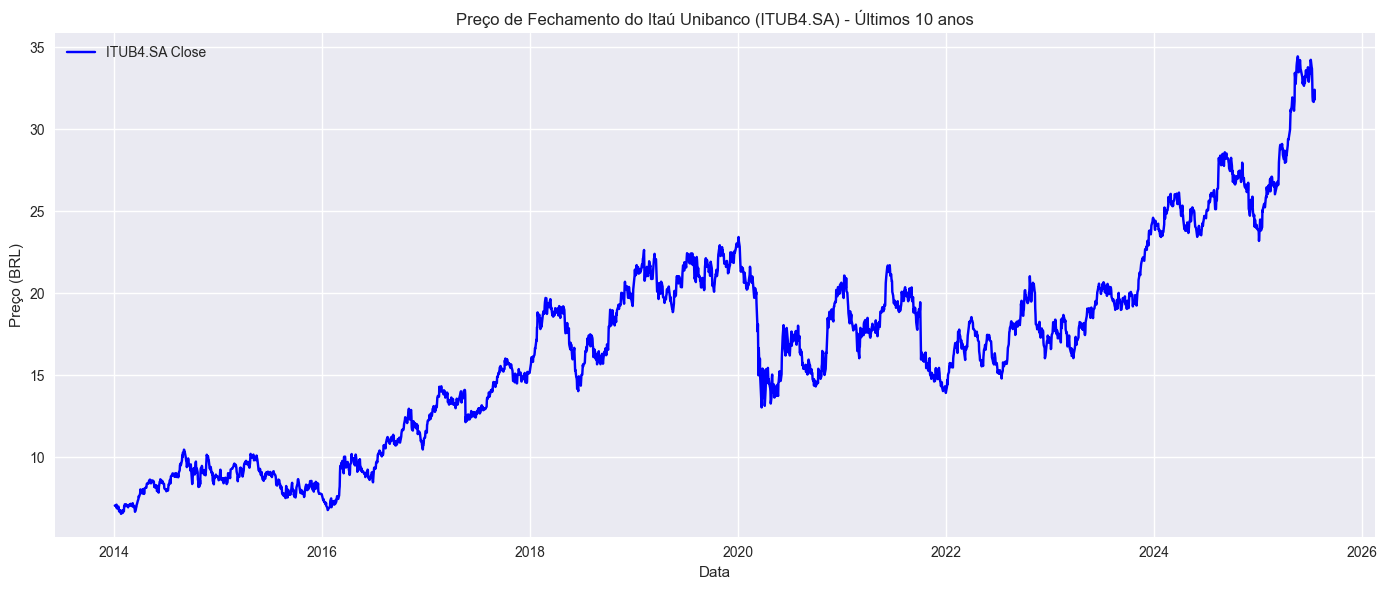

In [37]:
plt.figure(figsize=(14, 6))
plt.plot(df_final.index, df_final['Close'], label='ITUB4.SA Close', color='blue')
plt.title('Preço de Fechamento do Itaú Unibanco (ITUB4.SA) - Últimos 10 anos')
plt.xlabel('Data')
plt.ylabel('Preço (BRL)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **4.3 Histograma e Distribuição do Preço do Itaú**

Um histograma ajuda a entender como os preços de fechamento da ação estão distribuídos. Em ativos de renda variável bem estabelecidos, como o Itaú Unibanco, esperamos uma distribuição com assimetria moderada e caudas menos extremas — refletindo maior maturidade do mercado, regulamentação e base de investidores institucionais.

O gráfico abaixo combina o histograma com uma curva de densidade estimada (KDE), permitindo visualizar não apenas a frequência, mas também a forma suavizada da distribuição:

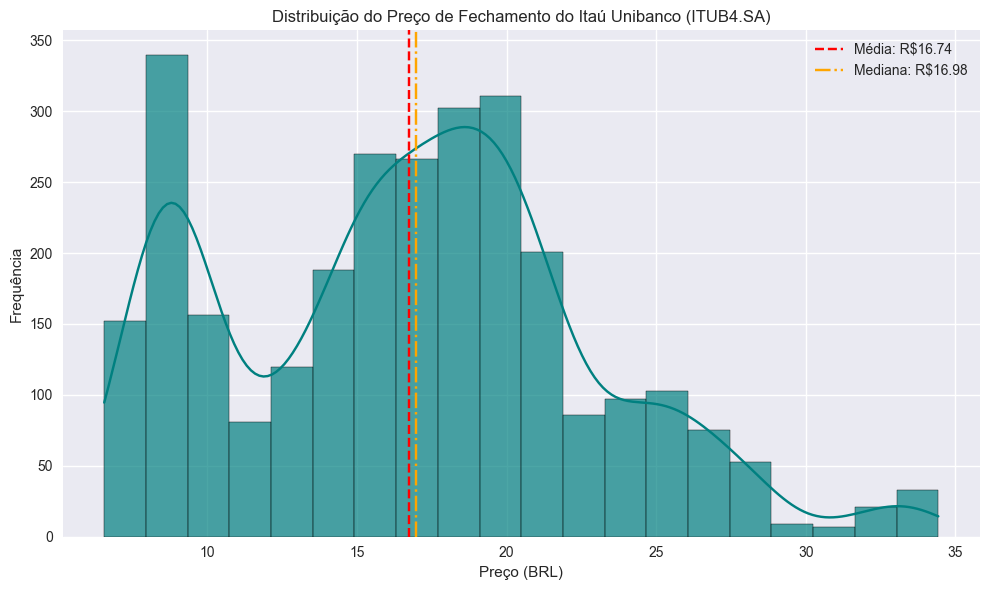

Média: R$16.74
Mediana: R$16.98
Desvio Padrão: R$6.02


In [38]:
plt.figure(figsize=(10, 6))
sns.histplot(df_final['Close'], bins=20, kde=True, color='teal', alpha=0.7)
plt.axvline(df_final['Close'].mean(), color='red', linestyle='--', label=f'Média: R${df_final["Close"].mean():,.2f}')
plt.axvline(df_final['Close'].median(), color='orange', linestyle='-.', label=f'Mediana: R${df_final["Close"].median():,.2f}')
plt.title('Distribuição do Preço de Fechamento do Itaú Unibanco (ITUB4.SA)')
plt.xlabel('Preço (BRL)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

# Imprimir as estatísticas para análise numérica
print(f"Média: R${df_final['Close'].mean():,.2f}")
print(f"Mediana: R${df_final['Close'].median():,.2f}")
print(f"Desvio Padrão: R${df_final['Close'].std():,.2f}")

### **4.4 Boxplot: Análise da Dispersão e Identificação de Outliers**

O boxplot (ou gráfico de caixa) é uma representação visual poderosa para entender a distribuição dos dados, destacando:

- Mediana (linha central)
- Quartis (caixa)
- Limites inferior e superior (bigodes)
- Valores atípicos (outliers), representados como pontos fora dos bigodes

No contexto do preço de fechamento da ação Itaú Unibanco (ITUB4.SA), espera-se moderada dispersão, típica de blue chips brasileiras. Embora o setor bancário seja sensível a choques macroeconômicos (ex: juros, câmbio, crises), movimentos extremos são menos frequentes que em criptoativos — o que reduz a probabilidade de outliers estatísticos.

A presença de outliers pode indicar:

- Eventos corporativos relevantes (lucros recordes, problemas regulatórios);
- Choques macroeconômicos (mudanças bruscas na Selic ou no câmbio);
- Erros de coleta ou ajustes históricos (split, agrupamento).

Vamos analisar o boxplot do preço de fechamento do Itaú para identificar possíveis valores discrepantes.

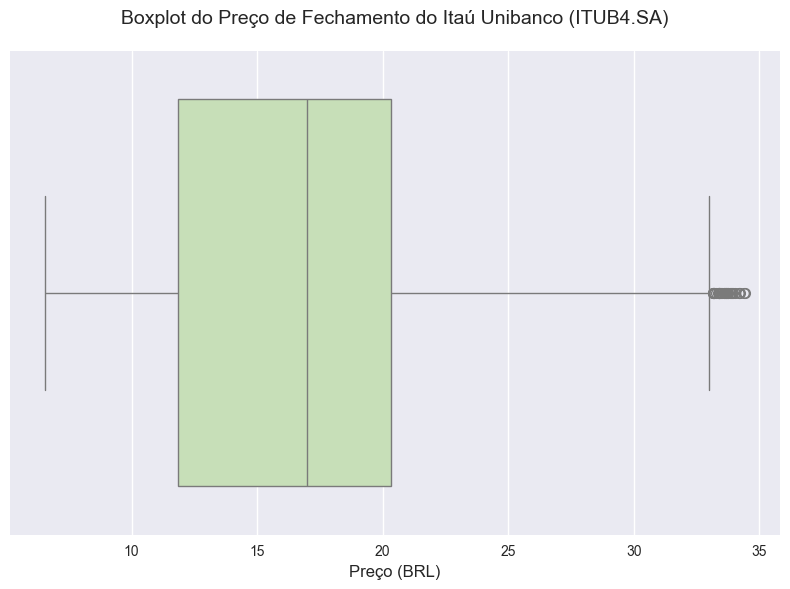

Número de outliers detectados: 33
Outliers encontrados:
                Close
Date                 
2025-05-09  33.426994
2025-05-13  33.157639
2025-05-14  33.382095
2025-05-15  33.831020
2025-05-16  34.028553
2025-05-19  34.432587
2025-05-20  34.387695
2025-05-21  33.696350
2025-05-22  33.462910
2025-05-23  33.866936
2025-05-26  33.938770
2025-05-27  34.208130
2025-05-28  33.929787
2025-05-29  33.660435
2025-05-30  33.606564
2025-06-02  33.370907
2025-06-03  33.263103
2025-06-04  33.182266
2025-06-12  33.190556
2025-06-16  33.390015
2025-06-17  33.589458
2025-06-18  33.390015
2025-06-20  33.217754
2025-06-23  33.145229
2025-06-24  33.770779
2025-06-25  33.163361
2025-06-30  33.498798
2025-07-01  33.650864
2025-07-02  33.378754
2025-07-03  34.204147
2025-07-04  34.222290
2025-07-07  33.768776
2025-07-08  33.687145


In [39]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_final['Close'], color='#c6e5b1')
plt.title('Boxplot do Preço de Fechamento do Itaú Unibanco (ITUB4.SA)', fontsize=14, pad=20)
plt.xlabel('Preço (BRL)', fontsize=12)
plt.tight_layout()
plt.show()

# Cálculo programático para identificar e quantificar os outliers
Q1 = df_final['Close'].quantile(0.25)
Q3 = df_final['Close'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar os outliers
outliers = df_final[(df_final['Close'] < limite_inferior) | (df_final['Close'] > limite_superior)]

print(f"Número de outliers detectados: {len(outliers)}")
if len(outliers) == 0:
    print("Nenhum outlier significativo encontrado — o comportamento do preço é relativamente consistente no período.")
else:
    print(f"Outliers encontrados:\n{outliers[['Close']]}")

### **4.5 Decomposição da Série Temporal**

A decomposição busca separar a série em tendência, sazonalidade e resíduos. No caso de ações listadas na B3 — como o Itaú Unibanco (ITUB4.SA) — não esperamos sazonalidade clássica (ex: padrões anuais fixos), pois os preços respondem principalmente a:

- Ciclos econômicos (PIB, inflação, juros);
- Política monetária do Banco Central;
- Resultados trimestrais da empresa.

Portanto, o componente "sazonal" tende a ser ruidoso ou inexistente. Ainda assim, a decomposição é útil para:

- Visualizar a tendência de longo prazo;
- Identificar desvios significativos (resíduos) associados a crises ou rallies.

Aplicamos a decomposição com period=252 (dias úteis em um ano), alinhado à convenção do mercado acionário brasileiro.

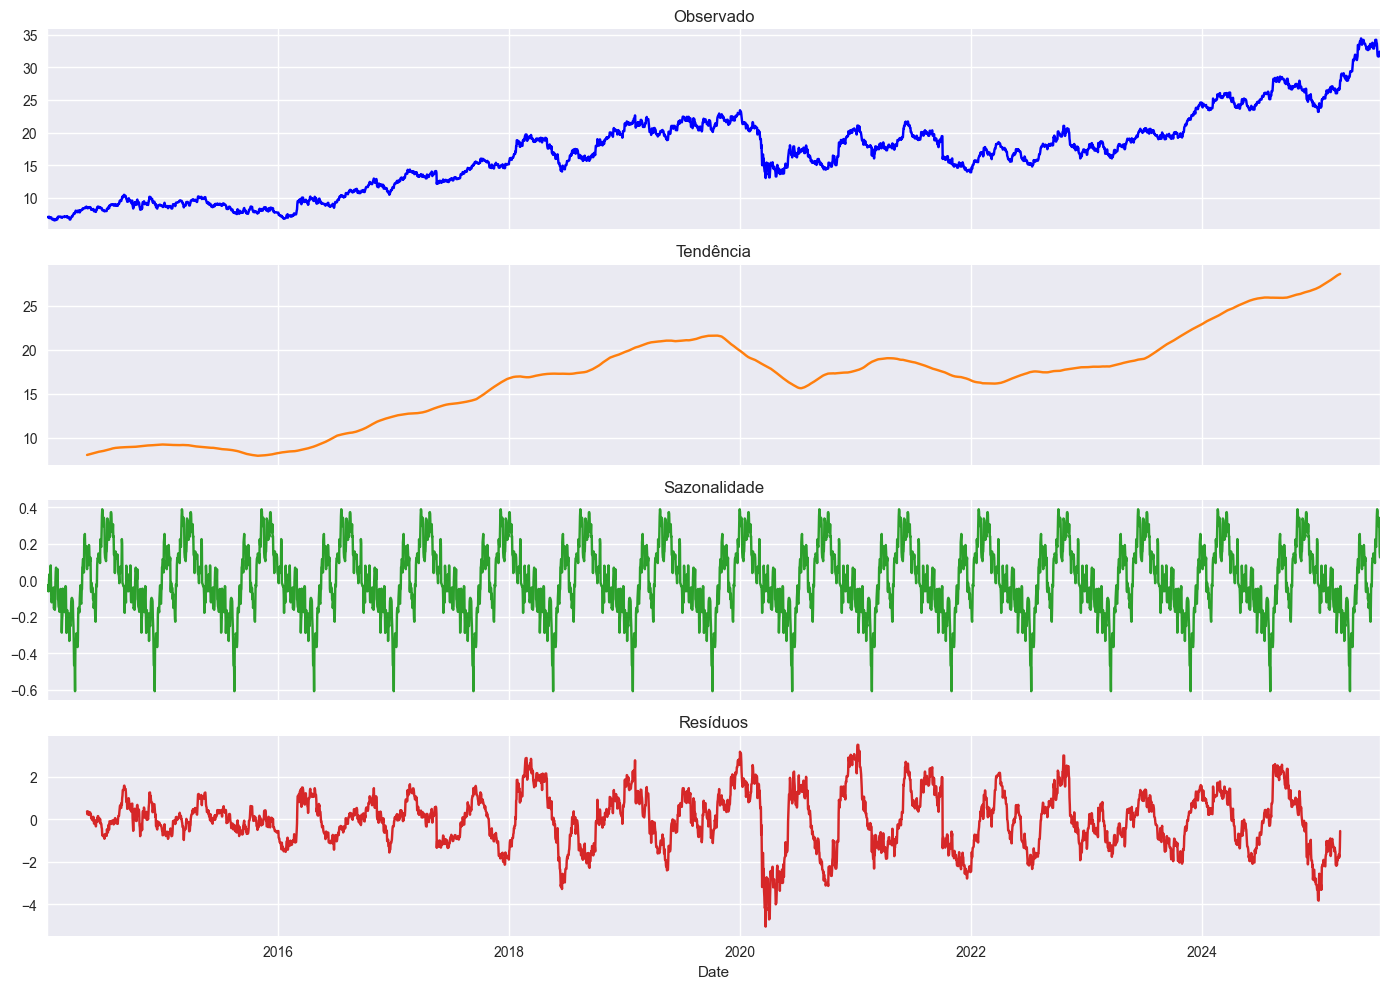

In [40]:
# Garantir frequência diária (útil para decomposição)
df_daily = df_final[['Close']].asfreq('D')

# Preencher lacunas com forward-fill (feriados/bancos fechados)
df_daily.fillna(method='ffill', inplace=True)
df_daily.dropna(inplace=True)

# Decompor com período anual (252 dias úteis)
result = seasonal_decompose(df_daily, model='additive', period=252)

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
result.observed.plot(ax=axes[0], title='Observado', color="blue")
result.trend.plot(ax=axes[1], title='Tendência', color='#ff7f0e')
result.seasonal.plot(ax=axes[2], title='Sazonalidade', color='#2ca02c')
result.resid.plot(ax=axes[3], title='Resíduos', color='#d62728')
plt.tight_layout()
plt.show()

### **4.6 Teste de Estacionariedade (ADF - Augmented Dickey-Fuller)**

Modelos clássicos de séries temporais exigem estacionariedade, mas ações raramente são estacionárias — elas apresentam tendências de longo prazo e volatilidade variável.

O teste ADF verifica:

- H₀: Há raiz unitária → série não é estacionária
- H₁: Não há raiz unitária → série é estacionária

Usamos α = 0.05. Se p-valor > 0.05, não rejeitamos H₀ (série não estacionária).

Espera-se que o preço do Itaú seja não estacionário, justificando o uso de modelos modernos como LSTM, que não exigem essa suposição.

In [41]:
adf_result = adfuller(df_final['Close'])

print('Estatística ADF:', adf_result[0])
print('p-valor:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

if adf_result[1] > 0.05:
    print("\nSérie NÃO é estacionária.")
else:
    print("\nSérie é estacionária.")

Estatística ADF: -0.8517381349611112
p-valor: 0.8034502227203943
Valores Críticos:
	1%: -3.4326393252891116
	5%: -2.8625514675886397
	10%: -2.5673084338969456

Série NÃO é estacionária.


### **4.7 Teste de Normalidade: Shapiro-Wilk**

Embora o LSTM seja robusto à normalidade, verificar a distribuição dos preços ajuda a entender o comportamento do ativo.

O teste de Shapiro-Wilk avalia:

- H₀: Dados seguem distribuição normal
- H₁: Dados não seguem distribuição normal

Em mercados financeiros, rejeitar H₀ é o resultado esperado devido à presença de caudas pesadas e eventos extremos.

In [42]:
stat, p_valor = shapiro(df_final['Close'])

print("TESTE DE NORMALIDADE (SHAPIRO-WILK)")
print(f"Estatística W: {stat:.8f}")
print(f"P-Valor: {p_valor:.8f}")

if p_valor < 0.05:
    print("\nRejeitamos H₀ → A distribuição não é normal.")
    print("Isso é esperado em ações, onde choques macroeconômicos geram volatilidade assimétrica.")
else:
    print("\nNão rejeitamos H₀ → A distribuição pode ser considerada normal.")

TESTE DE NORMALIDADE (SHAPIRO-WILK)
Estatística W: 0.96891787
P-Valor: 0.00000000

Rejeitamos H₀ → A distribuição não é normal.
Isso é esperado em ações, onde choques macroeconômicos geram volatilidade assimétrica.


## **5. Processamento dos Dados**

Agora que temos uma série temporal univariada limpa e bem estruturada — composta exclusivamente pelo preço de fechamento da ação Itaú Unibanco (ITUB4.SA) — precisamos processá-la para torná-la compatível com modelos de Machine Learning, especialmente redes neurais como o LSTM.

O processamento envolve etapas críticas:

- Definição da semente de reprodutibilidade: Garante que os resultados sejam reproduzíveis em diferentes execuções.
- Normalização: Mesmo em um modelo univariado, a normalização é essencial para estabilizar o treinamento da rede neural e acelerar a convergência do otimizador.
- Criação de sequências temporais: O LSTM requer janelas de tempo (ex: últimos 60 dias) para prever o próximo valor de fechamento. Essa abordagem, conhecida como sliding window, fornece contexto temporal ao modelo.
- Divisão treino/teste: Separamos os dados mantendo a ordem cronológica (sem embaralhamento), garantindo que o modelo seja avaliado em cenários futuros não vistos durante o treinamento.

Essa etapa é essencial para garantir que o modelo receba entradas consistentes, dimensionadas corretamente e com contexto temporal suficiente para aprender padrões complexos do mercado acionário brasileiro.

### 5.1 Definir a semente para reprodutibilidade

In [43]:
seed = 20
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

### 5.2 Normalização com MinMaxScaler

In [44]:
# Inicializar o scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Ajustar e transformar os dados (1 feature: Close)
scaled_data = scaler.fit_transform(df_final[['Close']])  # ← Só 'Close'

# Nota: O scaler final é salvo pelo script train.py para garantir reprodutibilidade.
# os.makedirs('models', exist_ok=True)
# joblib.dump(scaler, 'models/scaler_itau.pkl')
# print("Scaler salvo com 1 feature")

print("Dados normalizados com MinMaxScaler (escala 0 a 1)")
print(f"Forma dos dados normalizados: {scaled_data.shape}")
print(f"Exemplo - Antes: {df_final.iloc[0]['Close']:.2f}")
print(f"Exemplo - Depois: {scaled_data[0][0]:.4f}")

Dados normalizados com MinMaxScaler (escala 0 a 1)
Forma dos dados normalizados: (2871, 1)
Exemplo - Antes: 7.06
Exemplo - Depois: 0.0182


### 5.3 Criação de Sequências Temporais

In [45]:
def create_sequences(data, seq_length):
    """
    Cria sequências para uso em modelos LSTM.
    Entrada: janela de 'seq_length' dias (1 feature: Close)
    Saída: próximo valor do fechamento da ação
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])      # Janela de entrada (seq_length, 1)
        y.append(data[i + seq_length, 0])     # Próximo fechamento
    return np.array(X), np.array(y)

# Definir tamanho da janela (padrão para ações: 60 dias)
SEQ_LENGTH = 60

# Criar sequências
X, y = create_sequences(scaled_data, SEQ_LENGTH)

print(f"Sequências criadas com janela de {SEQ_LENGTH} dias")
print(f"Forma de X (entradas): {X.shape}")  # (n_amostras, 60, 1)
print(f"Forma de y (saídas): {y.shape}")   # (n_amostras,)

Sequências criadas com janela de 60 dias
Forma de X (entradas): (2811, 60, 1)
Forma de y (saídas): (2811,)


### 5.4 Divisão Treino/Teste (80/20)


Divisão dos Dados:
Treino - X: (2248, 60, 1), y: (2248,)
Teste - X: (563, 60, 1), y: (563,)


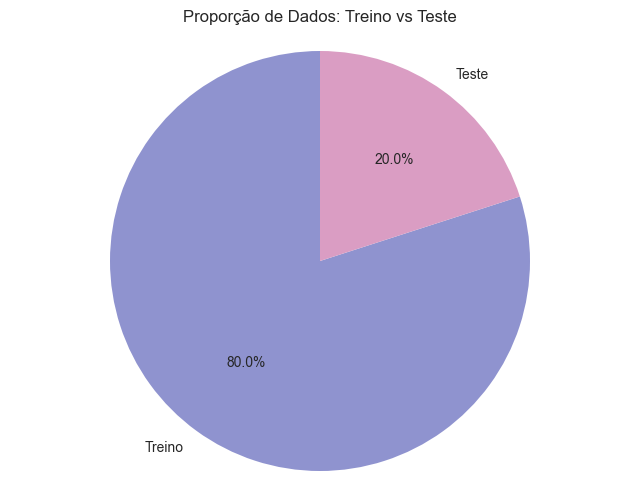

In [46]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("\nDivisão dos Dados:")
print(f"Treino - X: {X_train.shape}, y: {y_train.shape}")
print(f"Teste - X: {X_test.shape}, y: {y_test.shape}")

# Validação visual: mostrar tamanhos no gráfico
labels = ['Treino', 'Teste']
sizes = [len(X_train), len(X_test)]
colors = ["#8F93CF", "#DA9DC3"]

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Proporção de Dados: Treino vs Teste')
plt.axis('equal') 
plt.show()


### 5.5 Verificação do Formato para LSTM

In [47]:
print("\nFormato final esperado pelo LSTM:")
print(f"Entrada (X): (batch_size, time_steps, features) = ({X_train.shape[0]}, {X_train.shape[1]}, {X_train.shape[2]})")
print(f"Saída (y): (batch_size,) = ({y_train.shape[0]})")

# Confirmar que tudo está certo
assert X_train.shape[1] == SEQ_LENGTH, "Erro: time_steps incorreto"
assert X_train.shape[0] == len(y_train), "Erro: número de amostras não bate"
print("Todos os formatos estão corretos para o modelo LSTM.")


Formato final esperado pelo LSTM:
Entrada (X): (batch_size, time_steps, features) = (2248, 60, 1)
Saída (y): (batch_size,) = (2248)
Todos os formatos estão corretos para o modelo LSTM.


## **6. Modelagem com LSTM: Capturando Padrões de Longo Prazo**

O modelo LSTM (Long Short-Term Memory) é uma variação avançada das Redes Neurais Recorrentes (RNNs), especialmente projetado para lidar com dependências de longo prazo em séries temporais — exatamente o tipo de desafio que enfrentamos ao prever o preço de ações.

Diferentemente de modelos lineares, o LSTM consegue:

- "Lembrar" de padrões passados (como ciclos econômicos e tendências de mercado);
- Aprender não linearidades complexas;
- Adaptar-se a mudanças bruscas no comportamento do mercado.

Isso o torna particularmente eficaz mesmo em modelos univariados, onde toda a dinâmica preditiva vem da própria série histórica — sem depender de variáveis externas.

Neste projeto, treinamos um modelo LSTM com:

- Janela de entrada: últimos 60 dias
- Variável única: Close (ITUB4.SA)
- Objetivo: prever o preço de fechamento do Itaú no dia seguinte

Também incluímos técnicas de regularização para evitar overfitting: Dropout e EarlyStopping.

### 6.1 Construção do Modelo LSTM

In [48]:
### 6.1 Construção do Modelo LSTM
# Construir modelo
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),  # (60, 1)
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compilar o modelo
model_lstm.compile(optimizer='adam', loss='mse')

# Exibir resumo do modelo
print("Arquitetura do Modelo LSTM")
model_lstm.summary()

Arquitetura do Modelo LSTM


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

### 6.2 Treinamento do Modelo

In [49]:
# Callback: parar se não houver melhora
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Treinar modelo
print("Iniciando treinamento do modelo LSTM...")
history = model_lstm.fit(
    X_train, y_train,
    batch_size=32,  # aumentado para acelerar
    epochs=50,
    validation_split=0.1,  # útil para monitorar overfitting
    callbacks=[early_stop],
    verbose=1
)

print("Treinamento concluído!")

Iniciando treinamento do modelo LSTM...
Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.0092 - val_loss: 8.6076e-04
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0016 - val_loss: 7.3443e-04
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0014 - val_loss: 6.9893e-04
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0012 - val_loss: 7.5384e-04
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0011 - val_loss: 7.5972e-04
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0010 - val_loss: 8.5384e-04
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 9.3221e-04 - val_loss: 7.4819e-04
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 8.3821e-04 - val_loss: 5.7852e-04
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.8229e-04 - val_loss: 5.6549e-04
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.5034e-04 - val_loss: 5.4203e-04
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step -

### 6.3 Previsões no Conjunto de Teste

In [50]:
# Fazer previsões
pred_lstm = model_lstm.predict(X_test, verbose=0)

# Reverter escala (agora só 1 feature)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
pred_lstm_unscaled = scaler.inverse_transform(pred_lstm).flatten()

# Calcular métricas
mae_lstm = mean_absolute_error(y_test_unscaled, pred_lstm_unscaled)
rmse_lstm = np.sqrt(mean_squared_error(y_test_unscaled, pred_lstm_unscaled))
r2_lstm = r2_score(y_test_unscaled, pred_lstm_unscaled)
mape_lstm = mean_absolute_percentage_error(y_test_unscaled, pred_lstm_unscaled)

print(f"\nRESULTADOS DO MODELO LSTM")
print(f'MAE:  {mae_lstm:.2f} BRL')
print(f'RMSE: {rmse_lstm:.2f} BRL')
print(f'MAPE: {mape_lstm:.2f}%')
print(f'R²:   {r2_lstm:.4f}')


RESULTADOS DO MODELO LSTM
MAE:  0.40 BRL
RMSE: 0.51 BRL
MAPE: 0.02%
R²:   0.9845


### 6.4 Visualização: Previsão vs Real

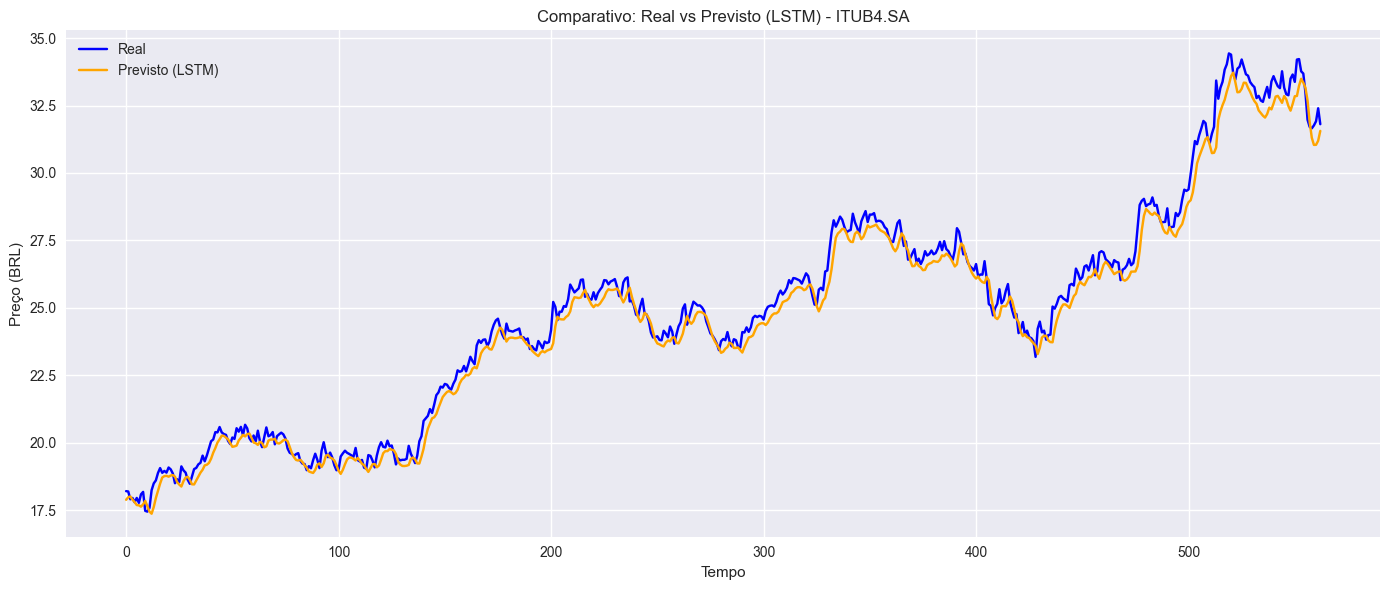

In [51]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_unscaled, label='Real', color='blue')
plt.plot(pred_lstm_unscaled, label='Previsto (LSTM)', color='orange')
plt.title('Comparativo: Real vs Previsto (LSTM) - ITUB4.SA')
plt.xlabel('Tempo')
plt.ylabel('Preço (BRL)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **7. Conclusão e Próximos Passos**

O modelo LSTM desenvolvido neste projeto demonstrou alta capacidade preditiva para o preço de fechamento da ação Itaú Unibanco (ITUB4.SA), com métricas robustas no conjunto de teste:

- R²: 0.9845 (98.45%)  
- MAE: R$ 0.40  
- RMSE: R$ 0.51  
- MAPE: 0.02%

Esses resultados confirmam que o LSTM é uma abordagem eficaz para modelar séries temporais financeiras, capturando tendências, padrões de volatilidade e dinâmicas não lineares presentes no mercado acionário brasileiro.
Direcionamento para Produção

O modelo foi integrado a uma API RESTful (FastAPI) e containerizado com Docker, seguindo boas práticas de MLOps:

- Treinamento reprodutível via train.py;
- Serviço leve e escalável via API;
- Entrega consistente em qualquer ambiente.

Esse fluxo permite que o modelo seja facilmente consumido por aplicações externas, como dashboards ou sistemas de apoio à decisão, garantindo agilidade e confiabilidade na operação.